In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import xgboost as xgb
from sklearn.cross_validation import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, auc, roc_curve
from sklearn.model_selection import learning_curve

os.chdir('/home/ankushraut/Downloads/inter_iit_tech')
data = pd.read_csv('ExoTrain.csv')

/home/ankushraut/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
data.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
1,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
2,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
3,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54
4,2,211.10,163.57,179.16,187.82,188.46,168.13,203.46,178.65,166.49,...,-98.45,30.34,30.34,29.62,28.80,19.27,-43.90,-41.63,-52.90,-16.16


In [3]:
target = pd.DataFrame({'LABEL':data.LABEL})
data = data.drop(labels = ['LABEL'], axis = 1)
target.LABEL.value_counts()

1    3927
2      33
Name: LABEL, dtype: int64

In [4]:
#random sampling into training and testing sets, test set contains 10% of the data

x_data, x_test, y_data, y_test = train_test_split(data, target, test_size = 0.1, random_state = 7, stratify = target)
x_data = x_data.reset_index(drop = True)
x_test = x_test.reset_index(drop = True)
y_data = y_data.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

In [5]:
y_data.LABEL.value_counts()

1    3534
2      30
Name: LABEL, dtype: int64

In [6]:
y_test.LABEL.value_counts()

1    393
2      3
Name: LABEL, dtype: int64

In [7]:
#random sampling into training and validation sets, validation set contains 15% of the training data

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size = .15, random_state = 7, stratify = y_data)
x_train = x_train.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
x_val = x_val.reset_index(drop = True)
y_val = y_val.reset_index(drop = True)

In [8]:
y_val.LABEL.value_counts()

1    530
2      5
Name: LABEL, dtype: int64

In [9]:
y_train.LABEL.value_counts()

1    3004
2      25
Name: LABEL, dtype: int64

In [10]:
#baseline approach : LABEL = 1
val = np.ones(len(y_train))
pred = np.ones(len(y_test))
print('macro f1 score on validation set = ',f1_score(y_train.LABEL, val, average = 'macro'))
print('macro f1 score on training set = ',f1_score(y_test.LABEL, pred, average = 'macro'))
print('micro f1 score on validation set = ',f1_score(y_train.LABEL, val, average = 'micro'))
print('micro f1 score on training set = ',f1_score(y_test.LABEL, pred, average = 'micro'))

macro f1 score on validation set =  0.497928062324
macro f1 score on training set =  0.498098859316
micro f1 score on validation set =  0.991746450974
micro f1 score on training set =  0.992424242424


/home/ankushraut/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [11]:
#converting 1 -> 0 and 2 -> 1 for convenience

def for_xgb(data):
    if data == 1:
        data = 0
    else:
        data = 1
    return data

y_train['LABEL'] = y_train['LABEL'].map(lambda x: for_xgb(x))
y_test['LABEL'] = y_test['LABEL'].map(lambda x: for_xgb(x))
y_val['LABEL'] = y_val['LABEL'].map(lambda x: for_xgb(x))

In [12]:
#xgboost

#the model would output probabilities
params = {"objective":"binary:logistic",
          "booster":"gbtree",
          "eta":0.1,
          "max_depth": 10,
         "subsample":0.75,
          "silent":0,
         "seed":7,
         "lambda":5,
         "alpha":5,
         "eval_metric":"logloss"}

#creating a dictionary to store progress

progress = dict()

num_boost_round = 100

x_tr = x_train
y_tr = y_train

dtrain = xgb.DMatrix(x_tr, y_tr)
dvalid = xgb.DMatrix(x_val, y_val) 

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

booster = xgb.train(params, dtrain, num_boost_round, evals = watchlist, evals_result = progress)

#training predictions
training_probs = booster.predict(xgb.DMatrix(x_train))
probs = []
for i in range(len(training_probs)):
    probs.append(training_probs[i])

#validation predictions
check = booster.predict(xgb.DMatrix(x_val))
check_values = []
for i in range(len(check)):
    check_values.append(check[i])

#test predictions
tester = booster.predict(xgb.DMatrix(x_test))
test_values = []
for i in range(len(tester)):
    test_values.append(tester[i])

[0]	train-logloss:0.602233	eval-logloss:0.602442
[1]	train-logloss:0.527552	eval-logloss:0.528309
[2]	train-logloss:0.46566	eval-logloss:0.466585
[3]	train-logloss:0.413319	eval-logloss:0.414727
[4]	train-logloss:0.368611	eval-logloss:0.370147
[5]	train-logloss:0.330048	eval-logloss:0.331759
[6]	train-logloss:0.296485	eval-logloss:0.29832
[7]	train-logloss:0.267487	eval-logloss:0.269467
[8]	train-logloss:0.24196	eval-logloss:0.244166
[9]	train-logloss:0.21976	eval-logloss:0.222361
[10]	train-logloss:0.200125	eval-logloss:0.203311
[11]	train-logloss:0.182672	eval-logloss:0.186091
[12]	train-logloss:0.167336	eval-logloss:0.170989
[13]	train-logloss:0.153646	eval-logloss:0.15793
[14]	train-logloss:0.141545	eval-logloss:0.14644
[15]	train-logloss:0.130634	eval-logloss:0.136091
[16]	train-logloss:0.121029	eval-logloss:0.12701
[17]	train-logloss:0.1124	eval-logloss:0.118813
[18]	train-logloss:0.104687	eval-logloss:0.111634
[19]	train-logloss:0.097929	eval-logloss:0.105305
[20]	train-logloss:

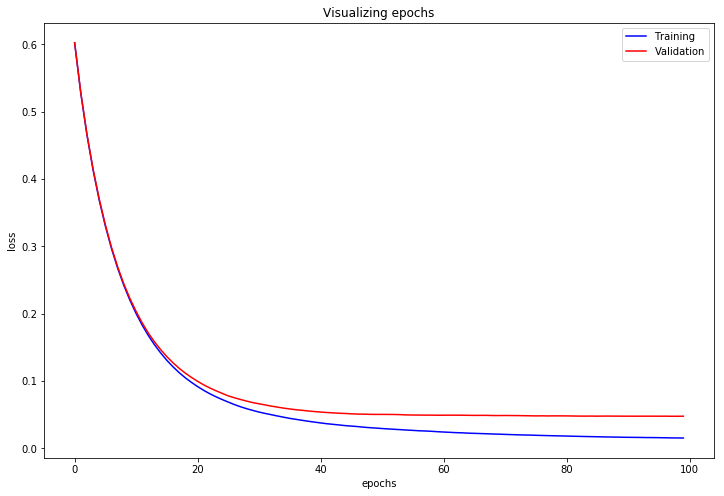

In [13]:
#visualizing the loss

training_loss = progress['train']['logloss']
validation_loss = progress['eval']['logloss']

plt.figure(figsize = (12, 8))
plt.plot(training_loss, color = 'blue', label = 'Training')
plt.plot(validation_loss, color = 'red', label = 'Validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Visualizing epochs')
plt.legend()
plt.show()

In [14]:
#checking auc_roc of all sets
print('roc_auc_score of training set = ', roc_auc_score(y_train, probs))
print('roc_auc_score of validation set = ', roc_auc_score(y_val, check_values))
print('roc_auc_score of test set = ', roc_auc_score(y_test, test_values))

roc_auc_score of training set =  0.999933422104
roc_auc_score of validation set =  0.820754716981
roc_auc_score of test set =  0.75657336726


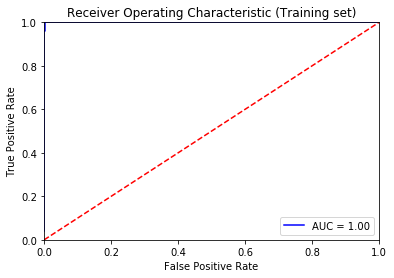

In [15]:
#plotting ROC for training set

# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = roc_curve(y_train, probs)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic (Training set)')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

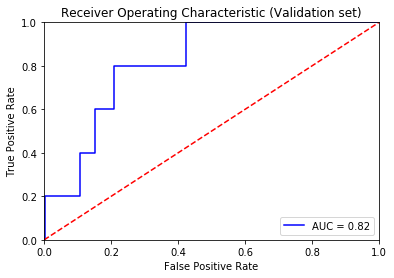

In [16]:
#plotting ROC for validation set

# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = roc_curve(y_val, check_values)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic (Validation set)')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

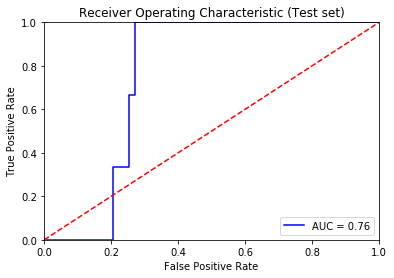

In [17]:
#plotting ROC for test set

# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = roc_curve(y_test, test_values)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic (Test set)')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [18]:
#reverse conversion into original labels

def reverse_xgb(data):
    if data == 0:
        data = 1
    else:
        data = 2
    return data
        
y_train['LABEL'] = y_train['LABEL'].map(lambda x: reverse_xgb(x))
y_test['LABEL'] = y_test['LABEL'].map(lambda x: reverse_xgb(x))
y_val['LABEL'] = y_val['LABEL'].map(lambda x: reverse_xgb(x))

In [19]:
#creation of validation predictions

validation = pd.DataFrame({'LABEL':check_values, 'actual':y_val})

In [20]:
#setting a threshold to separate probalities into the two different classes
#threshold has been set by visualizing the ROC for all sets

def converter(thresh, data):
    if data <= thresh:
        data = 1
    else:
        data = 2
    return data

validation['LABEL'] = validation['LABEL'].map(lambda x: converter(0.16, x))

In [21]:
#micro f1 score = total f1-score of the dataset
#macro f1 score = un-weighted average of f1 scores of individual classes


#performance on validation set
print('micro f1 score of validation set = ',f1_score(y_val, validation.LABEL, average = 'micro'))
print('macro f1 score of validation set = ',f1_score(y_val, validation.LABEL, average = 'macro'))

micro f1 score of validation set =  0.98691588785
macro f1 score of validation set =  0.60781233637


In [22]:
#creation of training set predictions

train_probs = pd.DataFrame({'LABEL':probs, 'actual':y_train})
train_probs['LABEL'] = train_probs['LABEL'].map(lambda x: converter(0.16, x))

In [23]:
#performance on training set

print('micro f1 score of training set = ',f1_score(y_train, train_probs.LABEL, average = 'micro'))
print('macro f1_score of training set = ',f1_score(y_train, train_probs.LABEL, average = 'macro'))

micro f1 score of training set =  0.999009574117
macro f1_score of training set =  0.967835563878


In [24]:
test_pred = pd.DataFrame({'LABEL':test_values, 'actual':y_test})
test_pred['LABEL'] = test_pred['LABEL'].map(lambda x: converter(0.16, x))

In [25]:
#performance on test set

print('micro f1 score of test set = ',f1_score(y_test, test_pred.LABEL, average = 'micro'))
print('macro f1 score of test set = ',f1_score(y_test, test_pred.LABEL, average = 'macro'))

micro f1 score of test set =  0.982323232323
macro f1 score of test set =  0.495541401274


In [26]:
confusion_matrix(y_train, train_probs.LABEL)

array([[3004,    0],
       [   3,   22]])

In [27]:
confusion_matrix(y_val, validation.LABEL)

array([[527,   3],
       [  4,   1]])

In [28]:
confusion_matrix(y_test, test_pred.LABEL)

array([[389,   4],
       [  3,   0]])

In [29]:
#store results

train_probs.to_csv('results_of_training_set.csv', index = False)
validation.to_csv('results_of_validation_set.csv', index = False)
test_pred.to_csv('results_of_test_set.csv', index = False)